In [ ]:
import os
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === CONFIG ===
data_root = "/content/drive/MyDrive/Colab Notebooks/MAIN_PROJECT/converted_hyperspectral_images/train"
bands = list(range(10, 30))   # your top 20 bands
resize_shape = (224, 224)
batch_size = 16
num_epochs = 30
lr = 1e-4
test_size = 0.2
random_seed = 42

# === DATASET ===
class HSISplitDataset(Dataset):
    def __init__(self, root, bands, resize):
        self.X, self.y = [], []
        self.classes = sorted(os.listdir(root))
        self.encoder = LabelEncoder().fit(self.classes)
        for cls in self.classes:
            for f in os.listdir(os.path.join(root, cls)):
                if not f.endswith(".mat"): continue
                mat = sio.loadmat(os.path.join(root, cls, f))
                hsi = mat["hyperspectral_image"][bands].astype(np.float32)
                hsi = (hsi - hsi.min())/(hsi.max()-hsi.min())
                t = torch.tensor(hsi)
                t = nn.functional.interpolate(t.unsqueeze(0), size=resize, mode="bilinear", align_corners=False).squeeze(0)
                self.X.append(t)
                self.y.append(cls)
        self.y_enc = self.encoder.transform(self.y)

    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y_enc[i]

# build full dataset
full_ds = HSISplitDataset(data_root, bands, resize_shape)

# stratified split
idx = np.arange(len(full_ds))
train_idx, val_idx = train_test_split(idx, stratify=full_ds.y_enc, test_size=test_size, random_state=random_seed)

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)

# === MODEL ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(len(bands), 64, 7, 2, 3, bias=False)
model.fc   = nn.Linear(model.fc.in_features, len(full_ds.classes))
model = model.to(device)

# weighted focal loss setup
class_weights = compute_class_weight("balanced", classes=np.unique(full_ds.y_enc), y=full_ds.y_enc)
alpha = torch.tensor(class_weights, dtype=torch.float32).to(device)
class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, inputs, targets):
        ce = nn.CrossEntropyLoss(weight=self.alpha, reduction="none")(inputs, targets)
        pt = torch.exp(-ce)
        return ((1-pt)**self.gamma * ce).mean()

criterion = FocalLoss(alpha, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# === TRAIN & VALIDATE ===
best_acc = 0
for epoch in range(1, num_epochs+1):
    model.train(); total_loss=0
    for X,y in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward(); optimizer.step()
        total_loss += loss.item()
    # validation
    model.eval(); preds, trues = [], []
    with torch.no_grad():
        for X,y in val_loader:
            X,y = X.to(device), y.to(device)
            out = model(X).argmax(1)
            preds.extend(out.cpu().numpy()); trues.extend(y.cpu().numpy())
    report = classification_report(trues, preds, target_names=full_ds.encoder.classes_, output_dict=True)
    acc = report["accuracy"]
    if acc>best_acc: best_acc=acc; torch.save(model.state_dict(),"best_resnet_hsi.pth")
    print(f"Epoch {epoch} | Train Loss {total_loss/len(train_loader):.4f} | Val Acc {acc:.4f}")

print(f"🏆 Best Validation Accuracy: {best_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]
Train Epoch 1: 100%|██████████| 186/186 [00:09<00:00, 19.48it/s]


Epoch 1 | Train Loss 1.0975 | Val Acc 0.3212


Train Epoch 2: 100%|██████████| 186/186 [00:07<00:00, 24.79it/s]


Epoch 2 | Train Loss 0.7073 | Val Acc 0.4656


Train Epoch 3: 100%|██████████| 186/186 [00:07<00:00, 25.67it/s]


Epoch 3 | Train Loss 0.4915 | Val Acc 0.5547


Train Epoch 4: 100%|██████████| 186/186 [00:07<00:00, 25.66it/s]


Epoch 4 | Train Loss 0.3245 | Val Acc 0.5587


Train Epoch 5: 100%|██████████| 186/186 [00:07<00:00, 25.57it/s]


Epoch 5 | Train Loss 0.1970 | Val Acc 0.6113


Train Epoch 6: 100%|██████████| 186/186 [00:07<00:00, 25.41it/s]


Epoch 6 | Train Loss 0.1462 | Val Acc 0.6221


Train Epoch 7: 100%|██████████| 186/186 [00:07<00:00, 24.86it/s]


Epoch 7 | Train Loss 0.1084 | Val Acc 0.5506


Train Epoch 8: 100%|██████████| 186/186 [00:07<00:00, 25.74it/s]


Epoch 8 | Train Loss 0.1078 | Val Acc 0.4656


Train Epoch 9: 100%|██████████| 186/186 [00:07<00:00, 25.68it/s]


Epoch 9 | Train Loss 0.0829 | Val Acc 0.6086


Train Epoch 10: 100%|██████████| 186/186 [00:07<00:00, 25.50it/s]


Epoch 10 | Train Loss 0.0886 | Val Acc 0.6248


Train Epoch 11: 100%|██████████| 186/186 [00:07<00:00, 25.84it/s]


Epoch 11 | Train Loss 0.0773 | Val Acc 0.6815


Train Epoch 12: 100%|██████████| 186/186 [00:07<00:00, 26.09it/s]


Epoch 12 | Train Loss 0.0657 | Val Acc 0.6154


Train Epoch 13: 100%|██████████| 186/186 [00:07<00:00, 24.88it/s]


Epoch 13 | Train Loss 0.0746 | Val Acc 0.6262


Train Epoch 14: 100%|██████████| 186/186 [00:07<00:00, 25.33it/s]


Epoch 14 | Train Loss 0.0990 | Val Acc 0.6370


Train Epoch 15: 100%|██████████| 186/186 [00:07<00:00, 25.34it/s]


Epoch 15 | Train Loss 0.0731 | Val Acc 0.6424


Train Epoch 16: 100%|██████████| 186/186 [00:07<00:00, 25.14it/s]


Epoch 16 | Train Loss 0.0632 | Val Acc 0.6694


Train Epoch 17: 100%|██████████| 186/186 [00:07<00:00, 25.53it/s]


Epoch 17 | Train Loss 0.0579 | Val Acc 0.6667


Train Epoch 18: 100%|██████████| 186/186 [00:07<00:00, 25.77it/s]


Epoch 18 | Train Loss 0.0630 | Val Acc 0.6437


Train Epoch 19: 100%|██████████| 186/186 [00:07<00:00, 25.20it/s]


Epoch 19 | Train Loss 0.0471 | Val Acc 0.6478


Train Epoch 20: 100%|██████████| 186/186 [00:07<00:00, 24.67it/s]


Epoch 20 | Train Loss 0.0531 | Val Acc 0.6721


Train Epoch 21: 100%|██████████| 186/186 [00:07<00:00, 24.64it/s]


Epoch 21 | Train Loss 0.0480 | Val Acc 0.6235


Train Epoch 22: 100%|██████████| 186/186 [00:07<00:00, 25.11it/s]


Epoch 22 | Train Loss 0.0700 | Val Acc 0.5857


Train Epoch 23: 100%|██████████| 186/186 [00:07<00:00, 24.67it/s]


Epoch 23 | Train Loss 0.0744 | Val Acc 0.6113


Train Epoch 24: 100%|██████████| 186/186 [00:07<00:00, 24.93it/s]


Epoch 24 | Train Loss 0.0499 | Val Acc 0.6559


Train Epoch 25: 100%|██████████| 186/186 [00:07<00:00, 24.90it/s]


Epoch 25 | Train Loss 0.0530 | Val Acc 0.6356


Train Epoch 26: 100%|██████████| 186/186 [00:07<00:00, 25.41it/s]


Epoch 26 | Train Loss 0.0537 | Val Acc 0.6505


Train Epoch 27: 100%|██████████| 186/186 [00:07<00:00, 24.82it/s]


Epoch 27 | Train Loss 0.0425 | Val Acc 0.7072


Train Epoch 28: 100%|██████████| 186/186 [00:07<00:00, 24.75it/s]


Epoch 28 | Train Loss 0.0347 | Val Acc 0.6302


Train Epoch 29: 100%|██████████| 186/186 [00:07<00:00, 24.39it/s]


Epoch 29 | Train Loss 0.0522 | Val Acc 0.6356


Train Epoch 30: 100%|██████████| 186/186 [00:07<00:00, 25.49it/s]


Epoch 30 | Train Loss 0.0592 | Val Acc 0.6842
🏆 Best Validation Accuracy: 0.7072


📊 Classification Report:
                             precision    recall  f1-score   support

         actinic_keratosis       0.62      0.65      0.63        80
                       bcc       0.69      0.75      0.72        80
            dermatofibroma       0.82      0.91      0.86        80
                  melanoma       0.60      0.69      0.64        88
                     nevus       0.59      0.60      0.59        80
pigmented_benign_keratosis       0.80      0.52      0.63        93
                       scc       0.65      0.60      0.62        80
      seborrheic_keratosis       0.75      0.75      0.75        80
           vascular_lesion       0.89      0.93      0.91        80

                  accuracy                           0.71       741
                 macro avg       0.71      0.71      0.71       741
              weighted avg       0.71      0.71      0.70       741



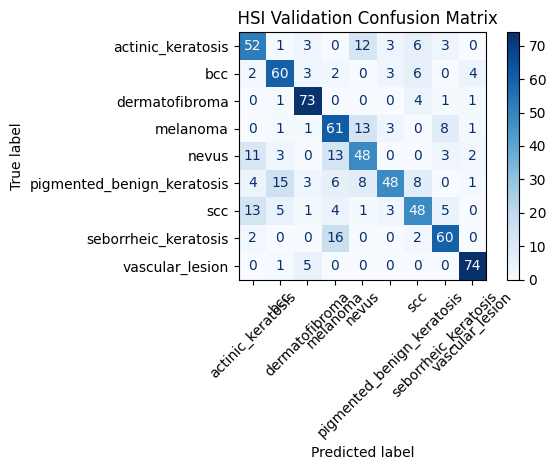

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === Load Best Model ===
model.load_state_dict(torch.load("best_resnet_hsi.pth"))
model.eval()

# === Run on Validation Set ===
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# === Generate Classification Report ===
target_names = full_ds.encoder.classes_
report = classification_report(all_labels, all_preds, target_names=target_names)
print("📊 Classification Report:\n", report)

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("  HSI Validation Confusion Matrix")
plt.tight_layout()
plt.show()


In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import importlib.util
import sys
import os
import scipy.io as sio  # To save as .mat file

# === 1. Dynamically load MST_Plus_Plus model from .py file ===
model_path = "/content/drive/MyDrive/Colab Notebooks/PROJECT/models/MST_Plus_Plus.py"
spec = importlib.util.spec_from_file_location("mstpp", model_path)
mstpp = importlib.util.module_from_spec(spec)
sys.modules["mstpp"] = mstpp
spec.loader.exec_module(mstpp)

MSTPlusPlus = mstpp.MST_Plus_Plus  # Access the class from the file

# === 2. Load model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MSTPlusPlus().to(device)

# Load your fine-tuned weights
model.load_state_dict(torch.load("/content/drive/MyDrive/mstpp_finetuned_skin_cancer.pth", map_location=device))
model.eval()


MST_Plus_Plus(
  (conv_in): Conv2d(3, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (body): Sequential(
    (0): MST(
      (embedding): Conv2d(31, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (encoder_layers): ModuleList(
        (0): ModuleList(
          (0): MSAB(
            (blocks): ModuleList(
              (0): ModuleList(
                (0): MS_MSA(
                  (to_q): Linear(in_features=31, out_features=31, bias=False)
                  (to_k): Linear(in_features=31, out_features=31, bias=False)
                  (to_v): Linear(in_features=31, out_features=31, bias=False)
                  (proj): Linear(in_features=31, out_features=31, bias=True)
                  (pos_emb): Sequential(
                    (0): Conv2d(31, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=31, bias=False)
                    (1): GELU()
                    (2): Conv2d(31, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

Saving ISIC_0024370.jpg to ISIC_0024370.jpg
✅ Predicted Skin Lesion: vascular_lesion


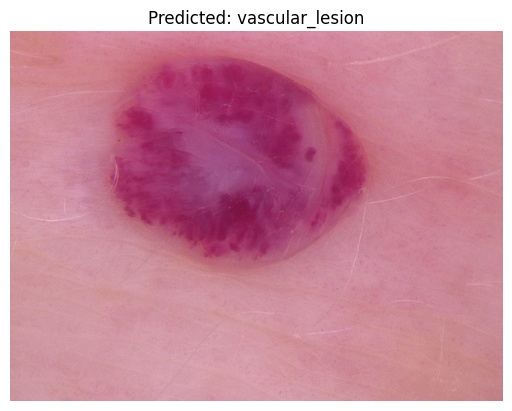

In [3]:
from google.colab import files
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
import os

# === 1. Upload Image ===
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = Image.open(img_path).convert("RGB")

# === 2. Preprocess RGB Image ===
transform = T.Compose([
    T.Resize((256, 256)),  # Match MST++ input
    T.ToTensor(),          # Convert to [C, H, W]
])
rgb_tensor = transform(img).unsqueeze(0).to(device)  # [1, 3, 256, 256]

# === 3. Convert RGB to HSI using MST++ ===
with torch.no_grad():
    hsi_output = model(rgb_tensor)  # [1, 31, 256, 256]
    hsi_bands = hsi_output[0, 10:30]  # [20, 256, 256]

# === 4. Resize to ResNet Input Shape ===
hsi_resized = F.interpolate(hsi_bands.unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False)

# === 5. Normalize to [0, 1] ===
hsi_resized = (hsi_resized - hsi_resized.min()) / (hsi_resized.max() - hsi_resized.min())

# === 6. Load ResNet Classifier ===
class_names = sorted(os.listdir("/content/drive/MyDrive/Colab Notebooks/MAIN_PROJECT/converted_hyperspectral_images/train"))
resnet = models.resnet18()
resnet.conv1 = nn.Conv2d(20, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.fc = nn.Linear(resnet.fc.in_features, len(class_names))
resnet.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/MAIN_PROJECT/best_resnet_hsi.pth", map_location=device))
resnet.to(device)
resnet.eval()

# === 7. Predict ===
with torch.no_grad():
    logits = resnet(hsi_resized.to(device))
    pred_class_idx = logits.argmax(1).item()
    pred_class_name = class_names[pred_class_idx]

# === 8. Output ===
print("✅ Predicted Skin Lesion:", pred_class_name)

# === 9. Optional: Show Image ===
plt.imshow(img)
plt.title(f"Predicted: {pred_class_name}")
plt.axis("off")
plt.show()
